In [1]:
# Inspired by https://www.kaggle.com/gunesevitan/advanced-feature-engineering-tutorial-with-titanic/notebook

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

SEED = 42

# Paths
titanic_path = Path('/kaggle/input/titanic')

In [2]:
def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

# Load the dataset
df_train = pd.read_csv(titanic_path/'train.csv')
df_test = pd.read_csv(titanic_path/'test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set'

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [3]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
134,135,0,2,"Sobey, Mr. Samuel James Hayden",male,25.0,0,0,C.A. 29178,13.0000,NaN,S
281,282,0,3,"Olsson, Mr. Nils Johan Goransson",male,28.0,0,0,347464,7.8542,NaN,S
330,331,1,3,"McCoy, Miss. Agnes",female,NaN,2,0,367226,23.2500,NaN,Q


In [4]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
59,951,1,"Chaudanson, Miss. Victorine",female,36.0,0,0,PC 17608,262.3750,B61,C
160,1052,3,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q
76,968,3,"Miles, Mr. Frank",male,NaN,0,0,359306,8.0500,NaN,S


# Deal with missing values
missing values in age, embarked and fare in small amounts
80% of cabin feature is missing

In [5]:
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
        
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)
    print('\n')

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




In [6]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age'] 

,Feature 1,Feature 2,Correlation Coefficient
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


In [7]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age for all passengers: {}'.format(df_all['Age'].median()))

# fill in missing values
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age for all passengers: 28.0


In [8]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [9]:
# researched needed to fill in this value
df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [10]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [11]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

{'A': {1: 22, 2: 0, 3: 0}, 'B': {1: 65, 2: 0, 3: 0}, 'C': {1: 94, 2: 0, 3: 0}, 'D': {1: 40, 2: 6, 3: 0}, 'E': {1: 34, 2: 4, 3: 3}, 'F': {1: 0, 2: 13, 3: 8}, 'G': {1: 0, 2: 0, 3: 5}, 'M': {1: 67, 2: 254, 3: 693}, 'T': {1: 1, 2: 0, 3: 0}}


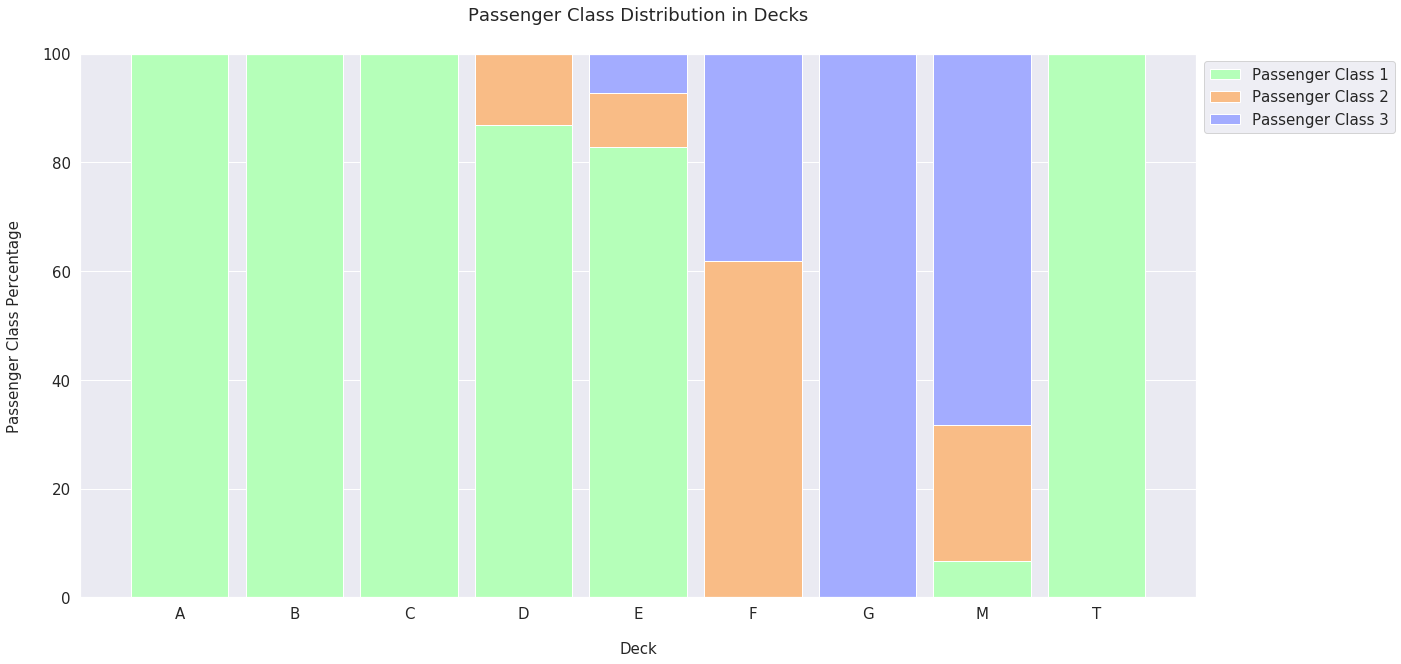

In [44]:
# Creating Deck column from the first letter of the Cabin Column (M stands for missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()
def get_pclass_dist(df):
    # Creating a dict for every passenger class count in every deck
    letters = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    deck_counts = {letter: {} for letter in letters}
    decks = df.columns.levels[0]
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count
            except KeyError:
                deck_counts[deck][pclass] = 0
    print(deck_counts)
                
    df_decks = pd.DataFrame(deck_counts)
    deck_percentages = {}
    
    # Creating a dict for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()
    
all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

In [33]:
all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)

A 1 22
{'A': {1: 22}, 'B': {1: 22}, 'C': {1: 22}, 'D': {1: 22}, 'E': {1: 22}, 'F': {1: 22}, 'G': {1: 22}, 'M': {1: 22}, 'T': {1: 22}}
B 1 65
{'A': {1: 65, 2: 0, 3: 0}, 'B': {1: 65, 2: 0, 3: 0}, 'C': {1: 65, 2: 0, 3: 0}, 'D': {1: 65, 2: 0, 3: 0}, 'E': {1: 65, 2: 0, 3: 0}, 'F': {1: 65, 2: 0, 3: 0}, 'G': {1: 65, 2: 0, 3: 0}, 'M': {1: 65, 2: 0, 3: 0}, 'T': {1: 65, 2: 0, 3: 0}}
C 1 94
{'A': {1: 94, 2: 0, 3: 0}, 'B': {1: 94, 2: 0, 3: 0}, 'C': {1: 94, 2: 0, 3: 0}, 'D': {1: 94, 2: 0, 3: 0}, 'E': {1: 94, 2: 0, 3: 0}, 'F': {1: 94, 2: 0, 3: 0}, 'G': {1: 94, 2: 0, 3: 0}, 'M': {1: 94, 2: 0, 3: 0}, 'T': {1: 94, 2: 0, 3: 0}}
D 1 40
{'A': {1: 40, 2: 0, 3: 0}, 'B': {1: 40, 2: 0, 3: 0}, 'C': {1: 40, 2: 0, 3: 0}, 'D': {1: 40, 2: 0, 3: 0}, 'E': {1: 40, 2: 0, 3: 0}, 'F': {1: 40, 2: 0, 3: 0}, 'G': {1: 40, 2: 0, 3: 0}, 'M': {1: 40, 2: 0, 3: 0}, 'T': {1: 40, 2: 0, 3: 0}}
D 2 6
{'A': {1: 40, 2: 6, 3: 0}, 'B': {1: 40, 2: 6, 3: 0}, 'C': {1: 40, 2: 6, 3: 0}, 'D': {1: 40, 2: 6, 3: 0}, 'E': {1: 40, 2: 6, 3: 0}, 'F'

In [35]:
t_l = ['a', 'b', 'c']
t_d = dict(zip(t_l, [{}] * len(t_l)))

In [38]:
t_d['a'] = 1
print(t_d)

{'a': 1, 'b': {}, 'c': {}}
